<a href="https://colab.research.google.com/github/Tsaraban/CM4145_NLP_coursework/blob/main/CE4145_coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CM4145 Natural Language Processing Coursework**
#### The aim of this coursework compare two NLP pipelines and determine the most suitable strategy for given task on the dataset.


##**Section 1:**

**Dataset :**

This project uses the emotiona_dataset_raw.csv from https://www.kaggle.com/datasets/mayurjare/emotion-datasets,
containing 8 Emotion Classes: 'joy', 'sadness', 'fear', 'anger', 'surprise', 'neutral', 'disgust', 'shame'. The task is to classify text samples into their corresponding emotion categories to enable human emotion recognition through text.

Detecting emotions in text is important for improving customer service, analysing social media posts, and finding peoples reaction to a certain content. Since manually labelling emotions is slow, subjective, and hard to scale, NLP methods are key to handling the huge amount of user-generated content online
The dataset presents several challenges that make it particularly interesting for NLP analysis.

The texts reflect everyday, informal language often seen on platforms like Twitter, messaging apps, and online forums, which makes emotion detection challenging, as emotions can be subtle, context-dependent, or expressed through sarcasm. The dataset may also show class imbalance, where some emotions appear more frequently than others, I will be taking some suggested steps for this issue.

In [1]:
#Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [2]:
#Loading the csv file I have saved in my drive.
#Please change the directory accordingly.
raw_df = pd.read_csv('/content/drive/MyDrive/4th year Coursework/CE4145_Coursework/emotion_dataset_raw.csv')

In [3]:
#dropna() function remove missing values from a DataFrame
df=(raw_df.dropna())

print(list(df.columns)) #Column names

print(df.shape) #shape

['Emotion', 'Text']
(34792, 2)


In [4]:
#Checking if there are any duplicate rows
duplicate_mask = df.duplicated(keep=False)
duplicate_count = duplicate_mask.sum()
duplicate_rows = df[duplicate_mask]

print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 6224



*Remove duplicate rows from 'df', keeping only the first occurrence.*
There are 6224 duplicate rows,
I will use the `drop_duplicates()` method on the `df` DataFrame to remove duplicate rows, keeping the first occurrence of each duplicate. This operation modifies the DataFrame `df` in place, ensuring that only unique rows remain.

In [5]:
df.drop_duplicates(inplace=True)
print(f"DataFrame shape after removing duplicates: {df.shape}")

DataFrame shape after removing duplicates: (31162, 2)


Exploring the dataset's each emotion to understand the class distribution and whether this dataset is imbalance or not.

In [6]:
#Getting percentage of each 8 emotions to get an idea about the balance of the dataset

print('anger:', round(raw_df['Emotion'].value_counts()['anger']/len(raw_df) * 100,2), '% of the dataset')
print('disgust:', round(raw_df['Emotion'].value_counts()['disgust']/len(raw_df) * 100,2), '% of the dataset')
print('fear:', round(raw_df['Emotion'].value_counts()['fear']/len(raw_df) * 100,2), '% of the dataset')
print('joy:', round(raw_df['Emotion'].value_counts()['joy']/len(raw_df) * 100,2), '% of the dataset')
print('neutral:', round(raw_df['Emotion'].value_counts()['neutral']/len(raw_df) * 100,2), '% of the dataset')
print('sadness:', round(raw_df['Emotion'].value_counts()['sadness']/len(raw_df) * 100,2), '% of the dataset')
print('shame:', round(raw_df['Emotion'].value_counts()['shame']/len(raw_df) * 100,2), '% of the dataset')
print('surprise:', round(raw_df['Emotion'].value_counts()['surprise']/len(raw_df) * 100,2), '% of the dataset')

#Getting count of each emotions
balance_counts = df.groupby('Emotion')['Emotion'].count()
balance_counts

anger: 12.35 % of the dataset
disgust: 2.46 % of the dataset
fear: 15.55 % of the dataset
joy: 31.75 % of the dataset
neutral: 6.48 % of the dataset
sadness: 19.32 % of the dataset
shame: 0.42 % of the dataset
surprise: 11.68 % of the dataset


,Emotion
Emotion,
anger,3777
disgust,855
fear,4266
joy,10464
neutral,1466
sadness,6175
shame,144
surprise,4015


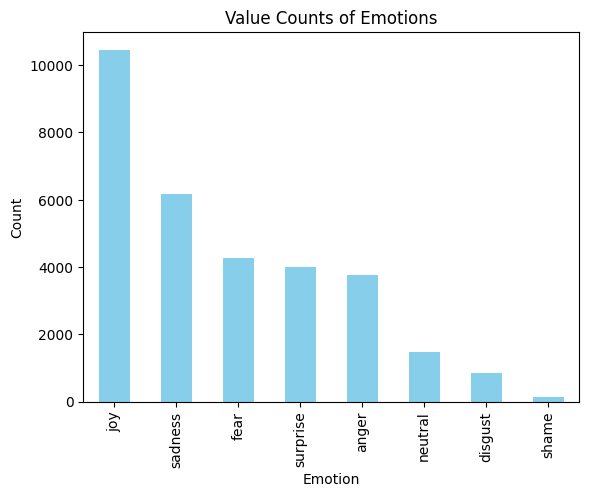

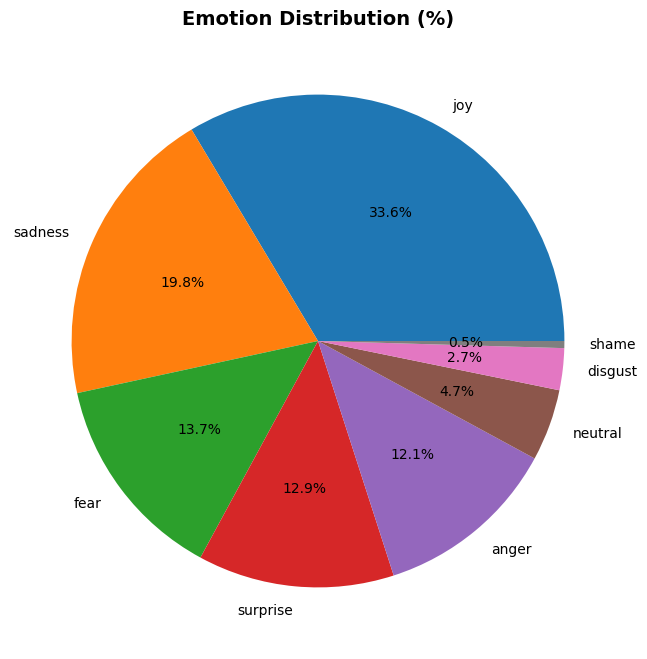

In [7]:
# Calculate value counts
counts = df['Emotion'].value_counts()

# Plot value counts
counts.plot(kind='bar', color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Value Counts of Emotions')
plt.show()

plt.figure(figsize=(8, 8))
df['Emotion'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Emotion Distribution (%)', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.show()

For being too little I will be removing shame and disgust.

DataFrame shape after removing 'shame' and 'disgust': (30163, 2)

Emotion distribution after removing 'shame' and 'disgust':
Emotion
joy         10464
sadness      6175
fear         4266
surprise     4015
anger        3777
neutral      1466
Name: count, dtype: int64


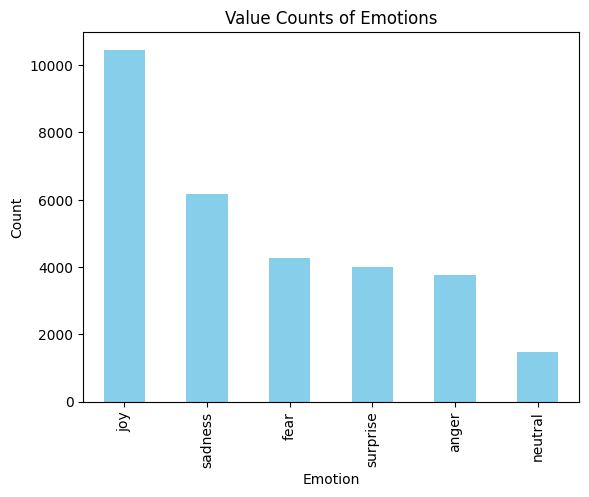

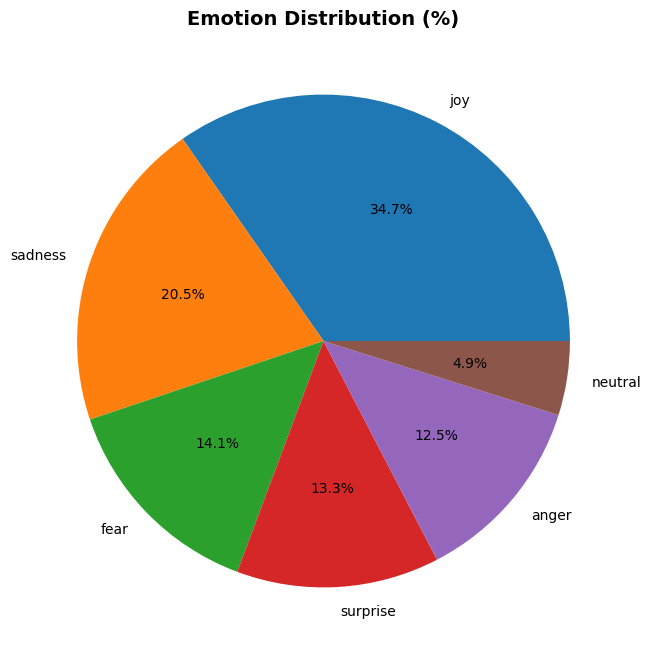

In [8]:
df = df[~df['Emotion'].isin(['shame', 'disgust'])]
print(f"DataFrame shape after removing 'shame' and 'disgust': {df.shape}")
print("\nEmotion distribution after removing 'shame' and 'disgust':")
print(df['Emotion'].value_counts())

# Calculate value counts
counts = df['Emotion'].value_counts()

# Plot value counts
counts.plot(kind='bar', color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Value Counts of Emotions')
plt.show()

plt.figure(figsize=(8, 8))
df['Emotion'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Emotion Distribution (%)', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.show()

In [9]:
# Text length analysis
df['text_length'] = df['Text'].str.len()
df['word_count'] = df['Text'].str.split().str.len()


print("TEXT LENGTH STATISTICS")

print(df[['text_length', 'word_count']].describe())


TEXT LENGTH STATISTICS
        text_length    word_count
count  30163.000000  30163.000000
mean      87.356065     16.348009
std       46.853897      9.120839
min        4.000000      1.000000
25%       55.000000     10.000000
50%       82.000000     15.000000
75%      115.000000     21.000000
max     1160.000000    261.000000


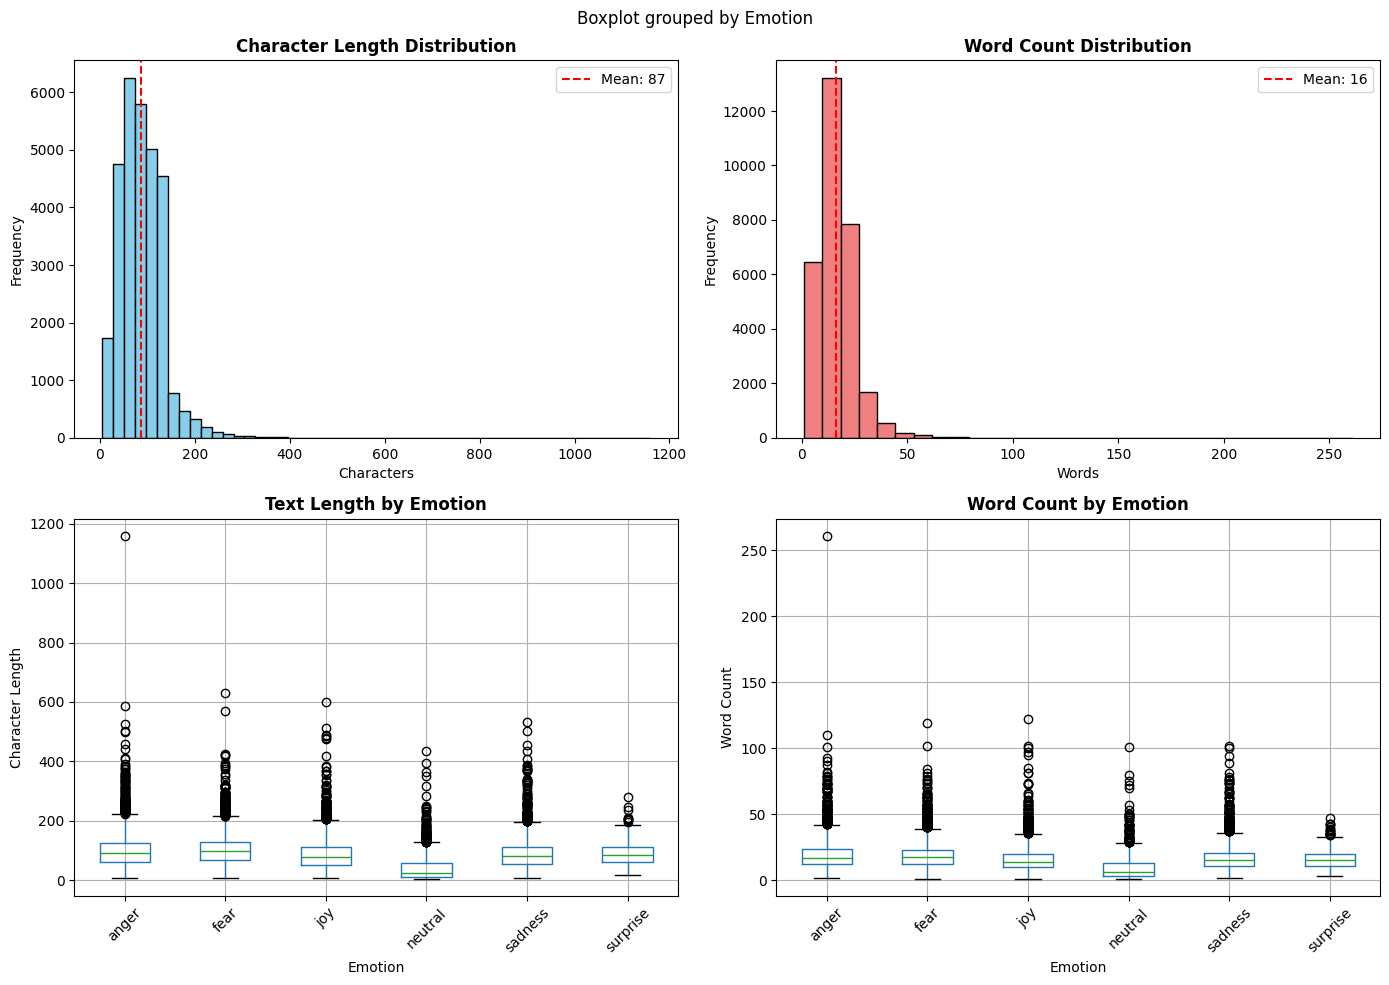

In [10]:
# Visualize text lengths
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Character length distribution
axes[0, 0].hist(df['text_length'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Character Length Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Characters')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["text_length"].mean():.0f}')
axes[0, 0].legend()

# Word count distribution
axes[0, 1].hist(df['word_count'], bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Word Count Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.0f}')
axes[0, 1].legend()

# Box plot by emotion
df.boxplot(column='text_length', by='Emotion', ax=axes[1, 0])
axes[1, 0].set_title('Text Length by Emotion', fontweight='bold')
axes[1, 0].set_xlabel('Emotion')
axes[1, 0].set_ylabel('Character Length')
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# Box plot word count
df.boxplot(column='word_count', by='Emotion', ax=axes[1, 1])
axes[1, 1].set_title('Word Count by Emotion', fontweight='bold')
axes[1, 1].set_xlabel('Emotion')
axes[1, 1].set_ylabel('Word Count')
plt.sca(axes[1, 1])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [11]:
# Sample texts per emotion

print("SAMPLE TEXTS PER EMOTION")
for emotion in df['Emotion'].unique():
    print(f"\n{emotion.upper()}:")
    samples = df[df['Emotion'] == emotion]['Text'].sample(min(3, len(df[df['Emotion'] == emotion])))
    for i, text in enumerate(samples, 1):
        print(f"  {i}. {text}")

SAMPLE TEXTS PER EMOTION

NEUTRAL:
  1.  What for ? 
  2.  Exactly ! 
  3.  has told U not to and not to be #afraid.  That should be good enough reason for you to enter this day with #fearless #confidence.

JOY:
  1. @sdrez Hey Delivery Boys! =) Giving you my daily dose of  and and #love ♥
  2. Winning a rowing race at a Karapiro regatta. With 7 other friends.
  3. Having a bit of 'me time' and getting my roots sorted out tonight...so they match the colour of the rest of my hair ;-) 

SADNESS:
  1. I wanted Taylor Swift or Katy Perry to be nominated for album of the year.......awk  
  2.  Sorry , but she ’ s out . 
  3. @CaitDemps07 sorry I made u wanna cry. I'm just gonna miss you :( 

FEAR:
  1. @BernardLeCroix I can confirm that that is true. Kissing them will give one the throw-up virus.  
  2. When a thunder belt hit the roof top of the building I was in.
  3. I have climbed it from all sides , every time making new discoveries , finding new surprises and delights and , let me con

The dataset is quite Imbalance now. After Clearing the dataset we will Look again for how imbalance it still are.

For text pre-processing I will be,
* Lowercase letters.
* Removing URLs.
* remove mentions and hashtags
* Removing punctuation.
* Spelling Correction.
* Removing stop words
* Handling Emojies
* Tokenization
* Lemmatization

The reason I have chosen Lemmatization over Stemmaing cause, Stemming is simpler and faster but less accurate, often producing non-words by cutting off prefixes or suffixes.
Meanwhile Lemmatization is more complex and accurate, considers context, converting words to their base forms using a dictionary.


In [12]:
import re
import string
from textblob import TextBlob # Import this Library to Handle the Spelling Issue.

import nltk #import the natural language toolkit

nltk.download('punkt') #download the package in nltk which supports tokenization
nltk.download('stopwords') #download the nltk package for stopwords
nltk.download('punkt_tab') # Download punkt_tab resource for NLTK tokenization
nltk.download('wordnet') # Download wordnet for lemmatization

from nltk.tokenize import word_tokenize #import the tokenize package
from nltk.corpus import stopwords #import the package from the corpus
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Here are some chatwords and emojis which I have collected from github, links are on top of each cell. With help of these I handled emojis and chat words.

In [13]:
#@title Code for Chatwords
# Repository Link : https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [14]:
# Function
def chat_conversion(text):
    new_text = []
    for i in text.split():
        if i.upper() in chat_words:
            new_text.append(chat_words[i.upper()])
        else:
            new_text.append(i)
    return " ".join(new_text)

In [15]:
#@title Code for Emoticons

EMOTICONS = {
    r":-\)": "Happy face or smiley",
    r":\)": "Happy face or smiley",
    r":-\]": "Happy face or smiley",
    r":\]": "Happy face or smiley",
    r":-3": "Happy face smiley",
    r":3": "Happy face smiley",
    r":->": "Happy face smiley",
    r":>": "Happy face smiley",
    r"8-\)": "Happy face smiley",
    r":o\)": "Happy face smiley",
    r":-\}": "Happy face smiley",
    r":\}": "Happy face smiley",
    r":-\)": "Happy face smiley",
    r":c\)": "Happy face smiley",
    r":\^\)": "Happy face smiley",
    r"=\]": "Happy face smiley",
    r"=\)": "Happy face smiley",
    r":-D": "Laughing, big grin or laugh with glasses",
    r":D": "Laughing, big grin or laugh with glasses",
    r"8-D": "Laughing, big grin or laugh with glasses",
    r"8D": "Laughing, big grin or laugh with glasses",
    r"X-D": "Laughing, big grin or laugh with glasses",
    r"XD": "Laughing, big grin or laugh with glasses",
    r"=D": "Laughing, big grin or laugh with glasses",
    r"=3": "Laughing, big grin or laugh with glasses",
    r"B\^D": "Laughing, big grin or laugh with glasses",
    r":-\)\)": "Very happy",
    r":-\(": "Frown, sad, andry or pouting",
    r":-\(": "Frown, sad, andry or pouting",
    r":\(": "Frown, sad, andry or pouting",
    r":-c": "Frown, sad, andry or pouting",
    r":c": "Frown, sad, andry or pouting",
    r":-<": "Frown, sad, andry or pouting",
    r":<": "Frown, sad, andry or pouting",
    r":-\[": "Frown, sad, andry or pouting",
    r":\[": "Frown, sad, andry or pouting",
    r":-\|\|": "Frown, sad, andry or pouting",
    r">:\[": "Frown, sad, andry or pouting",
    r":\{": "Frown, sad, andry or pouting",
    r":@": "Frown, sad, andry or pouting",
    r">:\(": "Frown, sad, andry or pouting",
    r":'-\(": "Crying",
    r":'\(": "Crying",
    r":'-\)": "Tears of happiness",
    r":'\)": "Tears of happiness",
    r"D-':": "Horror",
    r"D:<": "Disgust",
    r"D:": "Sadness",
    r"D8": "Great dismay",
    r"D;": "Great dismay",
    r"D=": "Great dismay",
    r"DX": "Great dismay",
    r":-O": "Surprise",
    r":O": "Surprise",
    r":-o": "Surprise",
    r":o": "Surprise",
    r":-0": "Shock",
    r"8-0": "Yawn",
    r">:O": "Yawn",
    r":-\*": "Kiss",
    r":\*": "Kiss",
    r":X": "Kiss",
    r";-\)": "Wink or smirk",
    r";\)": "Wink or smirk",
    r"\*-\)": "Wink or smirk",
    r"\*\)": "Wink or smirk",
    r";-\]": "Wink or smirk",
    r";\]": "Wink or smirk",
    r";\^\)": "Wink or smirk",
    r":-,": "Wink or smirk",
    r";D": "Wink or smirk",
    r":-P": "Tongue sticking out, cheeky, playful or blowing a raspberry",
    r":P": "Tongue sticking out, cheeky, playful or blowing a raspberry",
    r"X-P": "Tongue sticking out, cheeky, playful or blowing a raspberry",
    r"XP": "Tongue sticking out, cheeky, playful or blowing a raspberry",
    r":-Þ": "Tongue sticking out, cheeky, playful or blowing a raspberry",
    r":Þ": "Tongue sticking out, cheeky, playful or blowing a raspberry",
    r":b": "Tongue sticking out, cheeky, playful or blowing a raspberry",
    r"d:": "Tongue sticking out, cheeky, playful or blowing a raspberry",
    r"=p": "Tongue sticking out, cheeky, playful or blowing a raspberry",
    r">:P": "Tongue sticking out, cheeky, playful or blowing a raspberry",
    r":-/": "Skeptical, annoyed, undecided, uneasy or hesitant",
    r":/": "Skeptical, annoyed, undecided, uneasy or hesitant",
    r":-[.]": "Skeptical, annoyed, undecided, uneasy or hesitant",
    r">:[(\\\)]": "Skeptical, annoyed, undecided, uneasy or hesitant",
    r">:/": "Skeptical, annoyed, undecided, uneasy or hesitant",
    r":[(\\\)]": "Skeptical, annoyed, undecided, uneasy or hesitant",
    r"=/": "Skeptical, annoyed, undecided, uneasy or hesitant",
    r"=[(\\\)]": "Skeptical, annoyed, undecided, uneasy or hesitant",
    r":L": "Skeptical, annoyed, undecided, uneasy or hesitant",
    r"=L": "Skeptical, annoyed, undecided, uneasy or hesitant",
    r":S": "Skeptical, annoyed, undecided, uneasy or hesitant",
    r":-\|": "Straight face",
    r":\|": "Straight face",
    r":$": "Embarrassed or blushing",
    r":-x": "Sealed lips or wearing braces or tongue-tied",
    r":x": "Sealed lips or wearing braces or tongue-tied",
    r":-#": "Sealed lips or wearing braces or tongue-tied",
    r":#": "Sealed lips or wearing braces or tongue-tied",
    r":-&": "Sealed lips or wearing braces or tongue-tied",
    r":&": "Sealed lips or wearing braces or tongue-tied",
    r"O:-\)": "Angel, saint or innocent",
    r"O:\)": "Angel, saint or innocent",
    r"0:-3": "Angel, saint or innocent",
    r"0:3": "Angel, saint or innocent",
    r"0:-\)": "Angel, saint or innocent",
    r"0:\)": "Angel, saint or innocent",
    r":-b": "Tongue sticking out",
    r"0;\^\)": "Angel, saint or innocent",
    r">:-\)": "Evil or devilish",
    r">:\)": "Evil or devilish",
    r"\}:-\)": "Evil or devilish",
    r"\}:\)": "Evil or devilish",
    r"3:-\)": "Evil or devilish",
    r"3:\)": "Evil or devilish",
    r">;\)": "Evil or devilish",
    r"\|;-\)": "Cool",
    r"\|-O": "Bored",
    r":-J": "Tongue-in-cheek",
    r"#-\)": "Party all night",
    r"%-\)": "Drunk or confused",
    r"%\)": "Drunk or confused",
    r":-###..": "Being sick",
    r":###..": "Being sick",
    r"<:-\|": "Dump",
    r"\(>_<\)": "Troubled",
    r"\(>_<\)>": "Troubled",
    r"\(';'\)": "Baby",
    r"\(\^\^>``": "Nervous / Embarrassed",
    r"\(\^_\^;\)": "Nervous / Embarrassed",
    r"\(-_-;\)": "Nervous / Embarrassed",
    r"\(~_~;\) \(・\.・;\)": "Nervous / Embarrassed",
    r"\(-_-\)zzz": "Sleeping",
    r"\(\^_-\)": "Wink",
    r"\(\(\+_\+\)\)": "Confused",
    r"\(\+o\+\)": "Confused",
    r"\(o\|o\)": "Ultraman",
    r"\^_\^": "Joyful",
    r"\(\^_\^\)/": "Joyful",
    r"\(\^O\^\)／": "Joyful",
    r"\(\^o\^\)／": "Joyful",
    r"\(__\)": "Kowtow",
    r"_\(\._\.\)_": "Kowtow",
    r"<\(_ _\)>": "Kowtow",
    r"<m\(__\)m>": "Kowtow",
    r"m\(__\)m": "Kowtow",
    r"m\(_ _\)m": "Kowtow",
    r"\('_'\)": "Sad",
    r"\(/_;\)": "Sad",
    r"\(T_T\) \(;_;\)": "Sad",
    r"\(;_;": "Sad",
    r"\(;_:\)": "Sad",
    r"\(;O;\)": "Sad",
    r"\(:_;\)": "Sad",
    r"\(ToT\)": "Sad",
    r";_;": "Sad",
    r";-;": "Sad",
    r";n;": "Sad",
    r";;": "Sad",
    r"Q\.Q": "Sad",
    r"T\.T": "Sad",
    r"QQ": "Sad",
    r"Q_Q": "Sad",
    r"\(-\.-\)": "Shame",
    r"\(-_-\)": "Shame",
    r"\(一一\)": "Shame",
    r"\(；一_一\)": "Shame",
    r"\(=_=\)": "Tired",
    r"\(=\^\·\^=\)": "Cat",
    r"\(=\^\·\·\^=\)": "Cat",
    r"=_\^=": "Cat",
    r"\(\.\.\)": "Looking down",
    r"\(\._\.\)": "Looking down",
    r"\^m\^": "Giggling",
    r"\(\・\・\?": "Confusion",
    r"\(?_?\)": "Confusion",
    r">\^_\^<": "Laugh",
    r"<\^!\^>": "Laugh",
    r"\^/\^": "Laugh",
    r"\（\*\^_\^\*）": "Laugh",
    r"\(\^<\^\) \(\^\.\^\)": "Laugh",
    r"\(^\^\)": "Laugh",
    r"\(\^\.\^\)": "Laugh",
    r"\(\^_\^\.\)": "Laugh",
    r"\(\^_\^\)": "Laugh",
    r"\(\^\^\)": "Laugh",
    r"\(\^J\^\)": "Laugh",
    r"\(\*\^\.\^\*\)": "Laugh",
    r"\(\^—\^\）": "Laugh",
    r"\(#\^\.\^#\)": "Laugh",
    r"\（\^—\^\）": "Waving",
    r"\(;_;\)/~~~": "Waving",
    r"\(\^\.\^\)/~~~": "Waving",
    r"\(-_-\)/~~~ \($\·\·\)/~~~": "Waving",
    r"\(T_T\)/~~~": "Waving",
    r"\(ToT\)/~~~": "Waving",
    r"\(\*\^0\^\*\)": "Excited",
    r"\(\*_\*\)": "Amazed",
    r"\(\*_\*;": "Amazed",
    r"\(\+_\+\) \(@_@\)": "Amazed",
    r"\(\*\^\^\)v": "Cheerful",
    r"\(\^_\^\)v": "Cheerful",
    r"\(\(d[-_-]b\)\)": "Headphones",
    r"\(-\"-\)": "Worried",
    r"\(ーー;\)": "Worried",
    r"\(\^0_0\^\)": "Eyeglasses",
    r"\(\＾ｖ\＾\)": "Happy",
    r"\(\＾ｕ\＾\)": "Happy",
    r"\(\^\)o\(\^\)": "Happy",
    r"\(\^O\^\)": "Happy",
    r"\(\^o\^\)": "Happy",
    r"\)\^o\^\(": "Happy",
    r":O o_O": "Surprised",
    r"o_0": "Surprised",
    r"o\.O": "Surprised",
    r"\(o\.o\)": "Surprised",
    r"oO": "Surprised",
    r"\(\*￣m￣\)": "Dissatisfied",
    r"\(‘A`\)": "Snubbed"
}


function to remove emoji

In [16]:
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

There are so many opinions about emojis. It can be removed or used. In my case to detect emotions I feel emojis can play a great part. I will try both with and without emojis and see if it makes any different.

For pre_process I will be removing the emojis and pre_process2 I will converting emojis.

In [17]:
def pre_process(text):

    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@w+|#', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    #text = str(TextBlob(text=text).correct())
    #text = TextBlob(text).correct()
    text = chat_conversion(text)
    text = remove_emoticons(text)
    #stopwords
    words = text.split()
    filtered = [w for w in words if w not in stop_words]
    text = " ".join(filtered)
    #Tokenization
    tokens = word_tokenize(text)
    #print("TOKENS:", tokens) #For testing
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in tokens]
    text = " ".join(text)

    return text

In [18]:
df['pre_process'] = df['Text'].astype(str).apply(pre_process)
clean_df = df[df['pre_process'].str.strip() != ''] # getting rid of any empty Text rows.

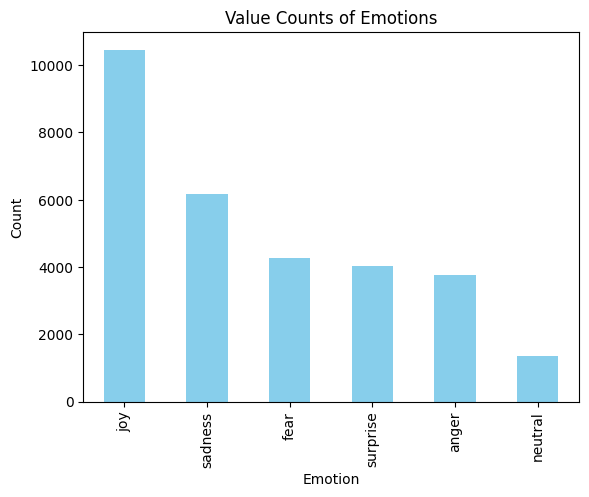

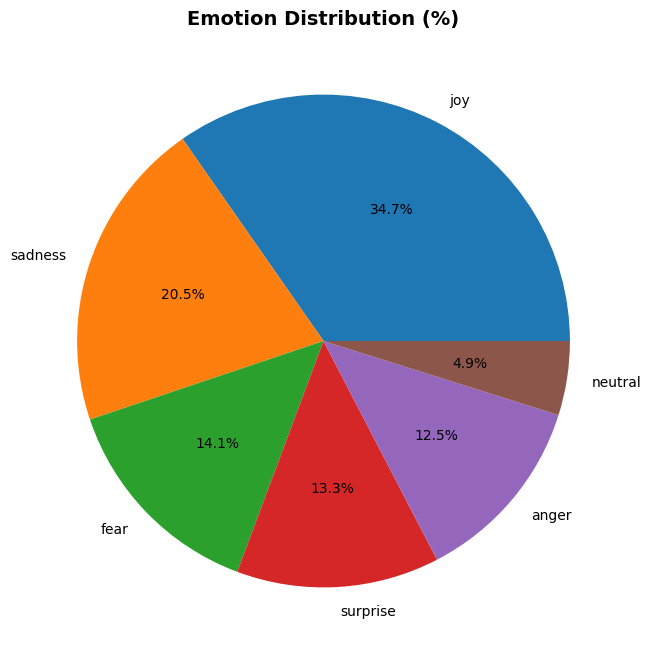

In [19]:
# Calculate value counts
counts = clean_df['Emotion'].value_counts()

# Plot value counts
counts.plot(kind='bar', color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Value Counts of Emotions')
plt.show()

plt.figure(figsize=(8, 8))
df['Emotion'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Emotion Distribution (%)', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.show()

In [20]:
# Text length analysis after cleaning
df['text_length'] = df['pre_process'].str.len()
df['word_count'] = df['pre_process'].str.split().str.len()


print("TEXT LENGTH STATISTICS")

print(df[['text_length', 'word_count']].describe())


TEXT LENGTH STATISTICS
        text_length    word_count
count  30163.000000  30163.000000
mean      56.642211      8.949441
std       30.578093      4.730583
min        0.000000      0.000000
25%       34.000000      6.000000
50%       53.000000      8.000000
75%       75.000000     12.000000
max      648.000000    105.000000


There are some changes in text_length and word_count after processing, such as mean text_length for raw data is 87.35 where after preparing its 56.64. same with word count, before it was 16.34 and now 8.94 and more.


Generating word clouds...


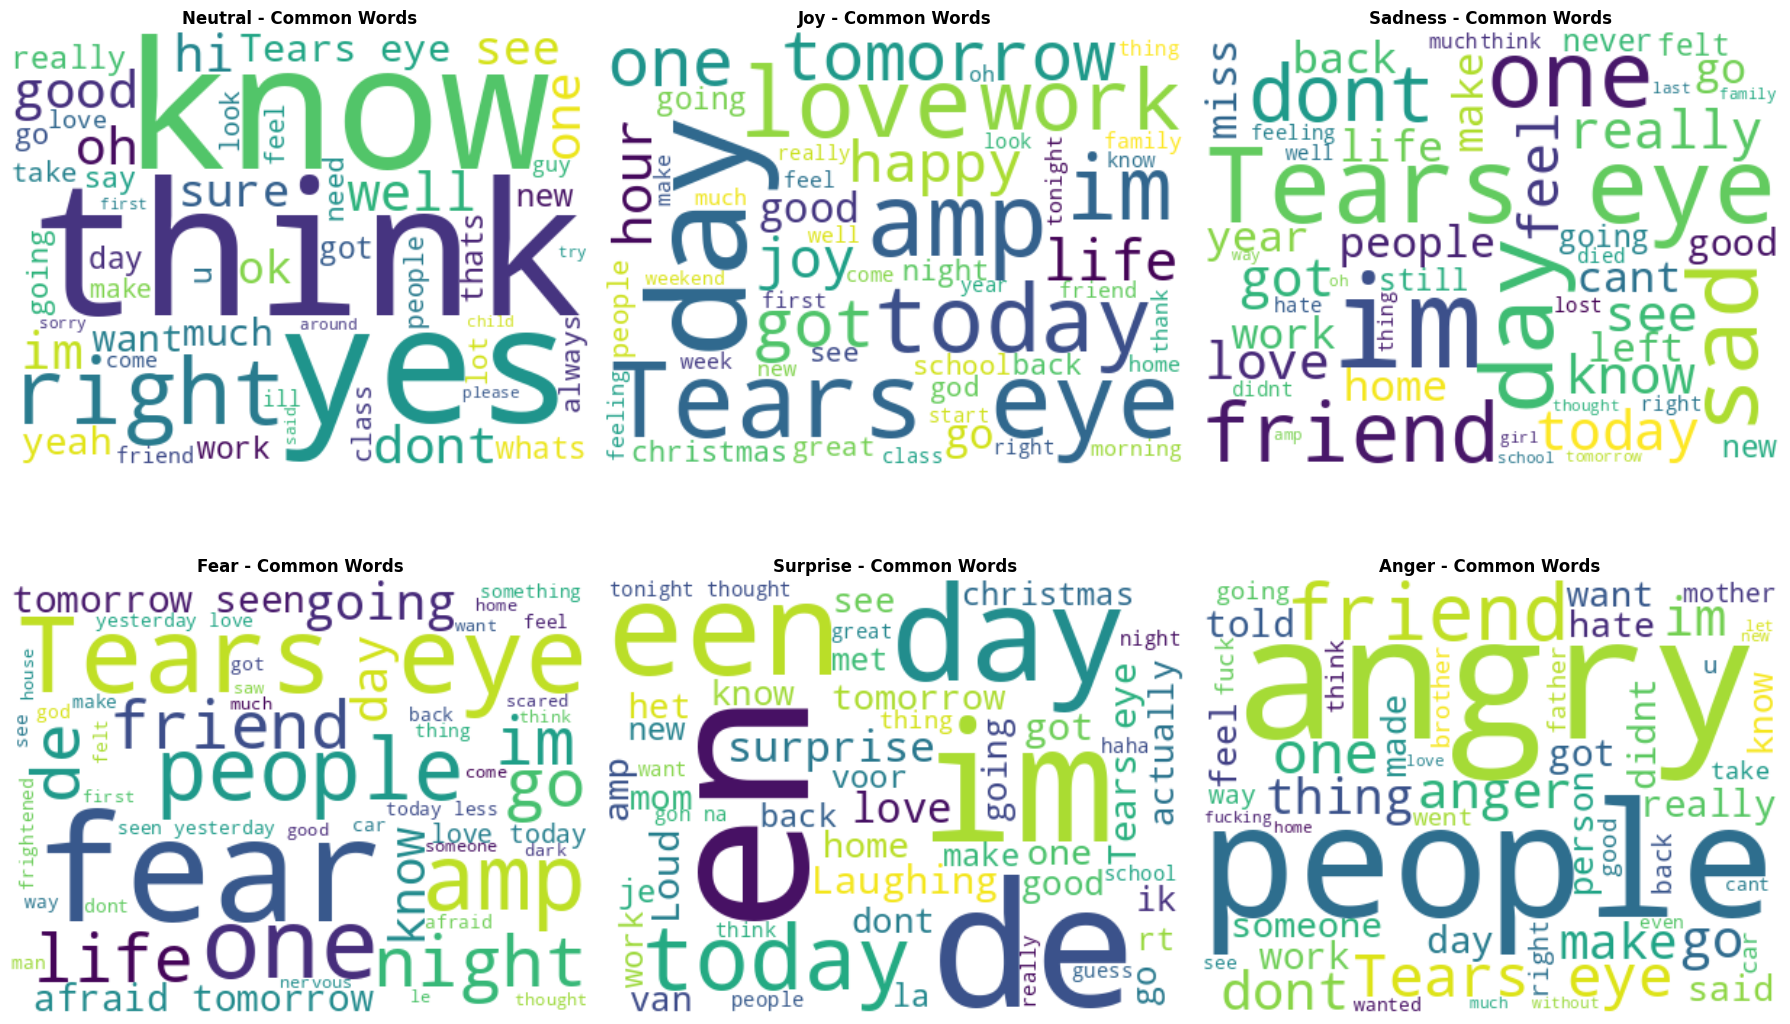

In [21]:
# Word clouds per emotion
print("\nGenerating word clouds...")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, emotion in enumerate(df['Emotion'].unique()[:6]):
    emotion_text = ' '.join(df[df['Emotion'] == emotion]['pre_process'])
    wordcloud = WordCloud(
        width=400, height=300,
        background_color='white',
        colormap='viridis',
        max_words=50
    ).generate(emotion_text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{emotion.capitalize()} - Common Words', fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

##**Section 2**
**Representation Learning**

For my classification I will be using Term Frequency - Inverse Document Frequency (TF-IDF) Vectorizer to convert the texual data into numerical representation. TF-IDF calculates a weight for each term by combining its frequency within a document with its inverse frequency across the corpus, providing a statistical measure of the term's importance in context (Anurag, 2024).

This approach is optimal for emotion detection as emotion bearing words
like 'happy', 'sad', or 'surprise' receive high weights due to
their discriminative value and relative rarity, while generic terms are
appropriately downweighted. To balance vocabulary coverage with computational efficiency, the vectorizer is restricted to max_features=5000, and ngram_range=(1,2) to capture both unigrams and bigrams.
Bigram inclusion is important for emotion detection and contextual phrases that
fundamentally alter meaning.

I will be performing LabelEncoder, as for multi-categorical classification as it is needed because machine learning models cannot process string labels such as happy, sad, or angry directly. It converts these categorical emotion classes into consistent numeric values, ensuring that each label is mapped to a unique integer. This transformation allows algorithms like MLPs or SVM classifiers, which I will apply to interpret the target variable correctly, enabling efficient training and evaluation across multiple emotion categories, and The parameter sublinear_tf=True applies logarithmic term frequency scaling, reducing the impact of repeated terms and improving generalization.
I will be using this TF-IDF vectorized values for both of my algorithms.

In [22]:
!pip install tensorflow

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [24]:
texts = df['pre_process'].astype(str)
labels = df['Emotion'].astype(str)

print(f"Total samples: {len(texts)}")
print(f"Emotion distribution:\n{labels.value_counts()}")

le = LabelEncoder()
y = le.fit_transform(labels)
y_cat = to_categorical(y)

num_classes = y_cat.shape[1]
print(f"\nNumber of classes: {num_classes}")

Total samples: 30163
Emotion distribution:
Emotion
joy         10464
sadness      6175
fear         4266
surprise     4015
anger        3777
neutral      1466
Name: count, dtype: int64

Number of classes: 6


In [25]:
# Test-Train Split (Stratified to balance)

X_train_text, X_test_text, y_train, y_test, y_train_cat, y_test_cat = train_test_split(
    texts, y, y_cat,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTrain samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")


Train samples: 24130
Test samples: 6033


In [26]:
print("TRAIN-TEST SPLIT")
print(f"Training samples: {len(X_train_text)} (80%)")
print(f"Testing samples: {len(X_test_text)} (20%)")

print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True) * 100)

print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True) * 100)

TRAIN-TEST SPLIT
Training samples: 24130 (80%)
Testing samples: 6033 (20%)

Class distribution in training set:
2    34.691256
4    20.472441
1    14.144219
5    13.311231
0    12.519685
3     4.861169
Name: proportion, dtype: float64

Class distribution in test set:
2    34.692524
4    20.470744
1    14.138903
5    13.310128
0    12.531079
3     4.856622
Name: proportion, dtype: float64


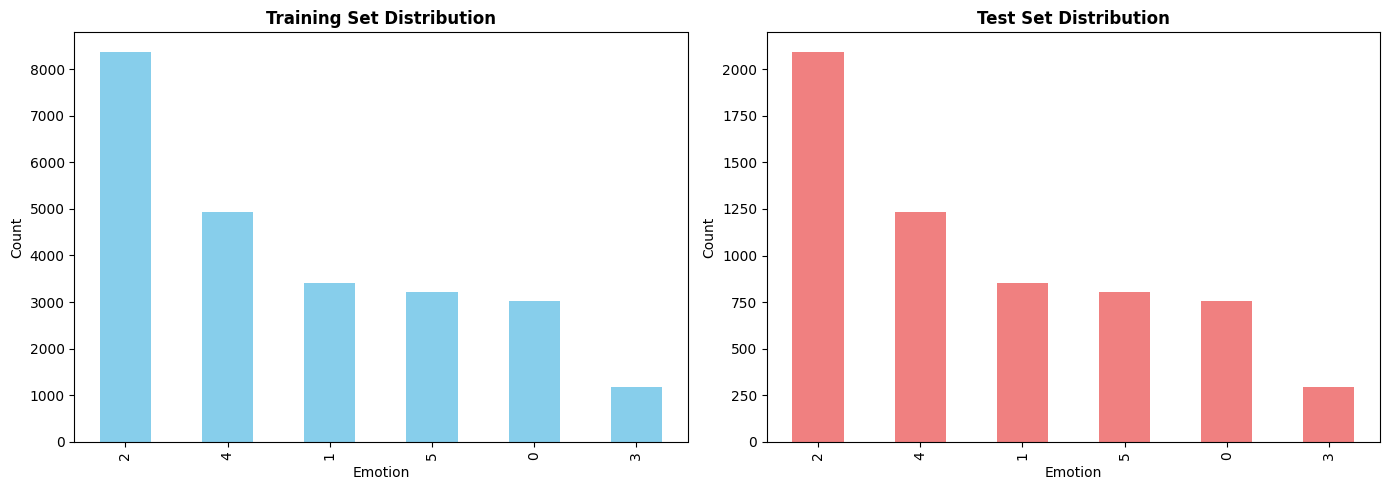

In [27]:
# Visualize split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Training Set Distribution', fontweight='bold')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')

pd.Series(y_test).value_counts().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Test Set Distribution', fontweight='bold')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [28]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    sublinear_tf=True
)

# Fit on training data ONLY
X_train = tfidf.fit_transform(X_train_text).astype("float32").toarray()
X_test = tfidf.transform(X_test_text).astype("float32").toarray()

TF-IDF matrix shape (train): (24130, 5000)
TF-IDF matrix shape (test): (6033, 5000)
Number of TF-IDF features: 5000

Top 30 Features by Total TF-IDF Score:
  im                  : 318.05
  day                 : 301.12
  eye                 : 272.64
  tears               : 248.80
  tears eye           : 248.80
  get                 : 241.41
  like                : 229.36
  today               : 228.05
  love                : 227.74
  one                 : 223.84


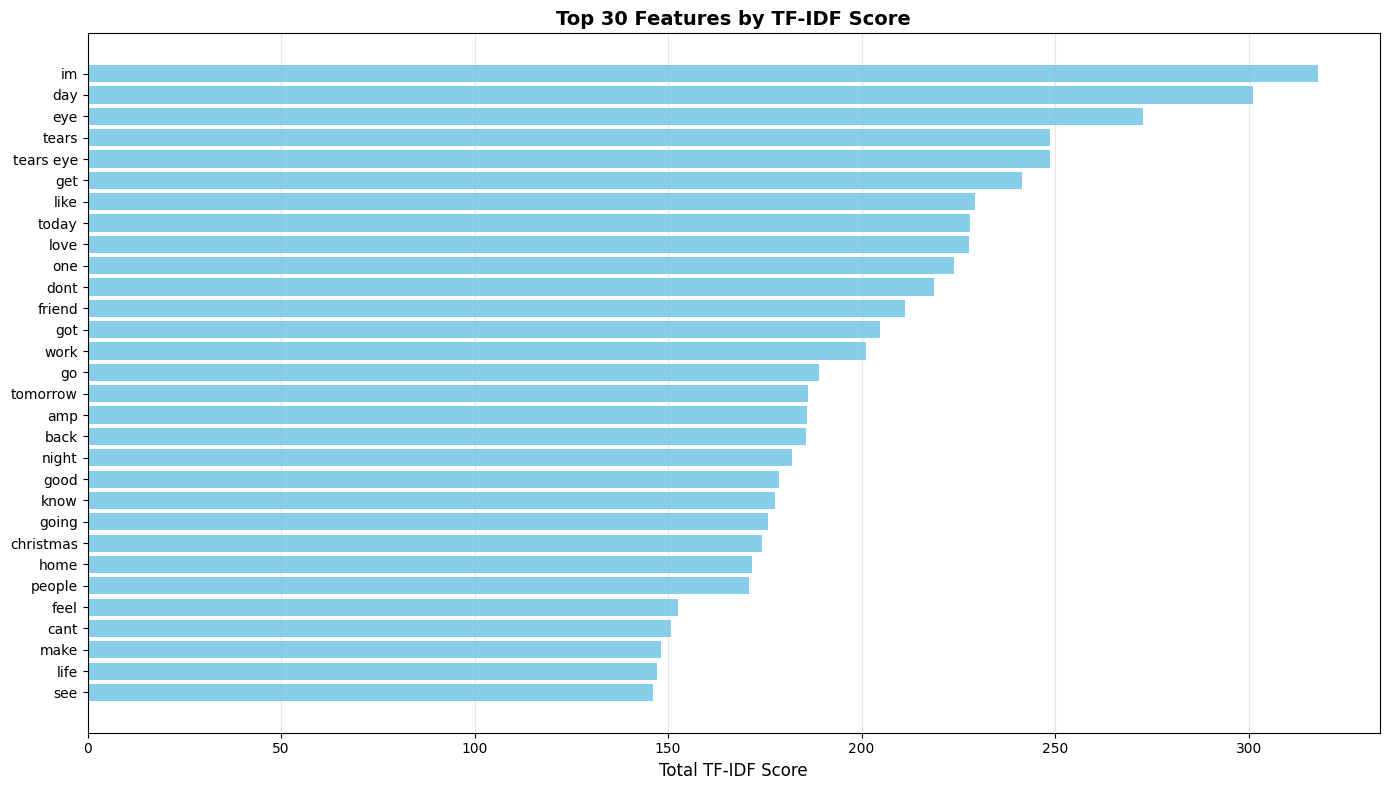

In [29]:
print(f"TF-IDF matrix shape (train): {X_train.shape}")
print(f"TF-IDF matrix shape (test): {X_test.shape}")

# Get feature names
feature_names = tfidf.get_feature_names_out()

# Number of TF-IDF features
num_features = len(feature_names)
print("Number of TF-IDF features:", num_features)

# Analyze top features by TF-IDF score
tfidf_scores = np.asarray(X_train.sum(axis=0)).flatten()
top_indices = tfidf_scores.argsort()[-30:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_scores = [tfidf_scores[i] for i in top_indices]

print("\nTop 30 Features by Total TF-IDF Score:")
for feat, score in zip(top_features[:10], top_scores[:10]):
    print(f"  {feat:20s}: {score:.2f}")

# Visualize top features
plt.figure(figsize=(14, 8))
plt.barh(range(len(top_features)), top_scores, color='skyblue')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Total TF-IDF Score', fontsize=12)
plt.title('Top 30 Features by TF-IDF Score', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

This code calculates balanced class weights so the model pays more attention to under-represented classes. compute_class_weight looks at how often each label appears in y_train and gives higher weights to rare classes. Then we convert the result into a dictionary (class_weight_dict) so it can be passed directly into the model during training.

In [30]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"\nClass weights: {class_weight_dict}")


Class weights: {0: np.float64(1.3312368972746331), 1: np.float64(1.1783377282937786), 2: np.float64(0.4804284633456775), 3: np.float64(3.4285308326229043), 4: np.float64(0.8141025641025641), 5: np.float64(1.2520755500207554)}


##**Section 3: Algorithms:**
For Classification of emotion dataset, two compared distinct machine learning
approaches are Support Vector Machines (SVM) and Multi-Layer
Perceptrons (MLP). These algorithms represent different paradigms - SVM as a
margin-based classifier and MLP as a neural network approach - providing
meaningful insights into which strategy suits this task. And both will be using same vectorization TF-IDF from section 2.

### **MLP**

For section 3 the first model I will be usiing to detect emotion through text is the Multi-Layer Perceptron (MLP) model which is a fully connected neural network designed for multi-class text classification using TF-IDF features. The input layer receives the TF-IDF vector for each text sample, where each value represents the importance of a word in the training data. The first hidden layer contains 128 neurons with ReLU activation, allowing the model to learn non-linear patterns. L2 regularization is applied to reduce overfitting by penalizing overly large weights, and a dropout rate of 0.5 further improves generalization by randomly disabling half of the neurons during training. A second hidden layer with 64 neurons and 0.4 dropout helps the network learn more abstract patterns.

The final output layer uses softmax activation to produce probability scores for each emotion category. The model is trained using the Adam optimizer and categorical cross-entropy loss, which is suitable for multi-class problems like emotions.

EarlyStopping and ReduceLROnPlateau callbacks were included but left commented out in the provided run, enabling them would automatically stop overfitting and reduce the learning rate when progress slows but does not give good accuracy score. Similarly, Class weights were prepared but not applied for same reason.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

model = Sequential([
    # Layer 1
    Dense(128, activation='relu',
          kernel_regularizer=l2(0.01),
          input_shape=(X_train.shape[1],)),
    Dropout(0.5),

    # Layer 2
    Dense(64, activation='relu',
          kernel_regularizer=l2(0.01)),
    Dropout(0.4),

    # Output layer
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


model.summary()


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)


history = model.fit(
    X_train, y_train_cat,
    epochs=55,
    batch_size=32,
    validation_split=0.2,
    #class_weight=class_weight_dict,
    #callbacks=[early_stop, reduce_lr],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,774 (2.47 MB)

 Trainable params: 648,774 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/55
604/604 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.3390 - loss: 2.1189 - val_accuracy: 0.3456 - val_loss: 1.6509
Epoch 2/55
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.3470 - loss: 1.6597 - val_accuracy: 0.3456 - val_loss: 1.6477
Epoch 3/55
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3467 - loss: 1.6473 - val_accuracy: 0.3456 - val_loss: 1.6469
Epoch 4/55
604/604 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3425 - loss: 1.6527 - val_accuracy: 0.3456 - val_loss: 1.6466
Epoch 5/55
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.3427 - loss: 1.6508 - val_accuracy: 0.3456 - val_loss: 1.6446
Epoch 6/55
604/604 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3558 - loss: 1.6399 - val_accuracy: 0.3456 - val_loss: 1.6448
Epoch 7/55
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.3479 - loss: 1.6453 - val_accuracy: 0.3456 - val_loss: 1.6439
Epoch 8/55
604/604 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3476 - loss: 1.6462 - val_ac

### **SVM**

Support Vector Machines (SVMs) are strong baseline models for multi-class text classification,specially combined with TF-IDF representation. For my project as second NLP Algorithm I have considered  Linear Support Vector Classifier (LinearSVC), according to scikit-learn LinearSVC computationally efficient for high-dimensional sparse data.

I have put C = 1.0, which controls the trade-off between margin size and classification errors. A moderate C value allows the model to generalize better rather than perfectly fit the training data. I have set dual=False as the number of samples is larger than the number of features after vectorization, making the primal optimization faster. The option class_weight='balanced' automatically adjusts weights based on class frequency, helping the model handle emotion categories that appear less often as dataset is bit imbalanced.

Because LinearSVC does not provide calibrated probabilities natively, I wrap it with CalibratedClassifierCV using 3 fold cross-validation. This provides reliable probability estimates needed for certain evaluation metrics and downstream analysis. Overall, this setup balances speed, generalization, and interpretability, making it a strong choice for multiclass text classification tasks.

In [32]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [33]:
svm_base = LinearSVC(
    C=1.0,
    max_iter=1000,
    random_state=42,
    dual=False,
    class_weight='balanced'
)

svm_model = CalibratedClassifierCV(svm_base, cv=3)
svm_model.fit(X_train, y_train)
print("Linear SVM with probability calibration complete")

Linear SVM with probability calibration complete


## **Section 4: Evaluation:**


Generating Predictions
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion Matrics


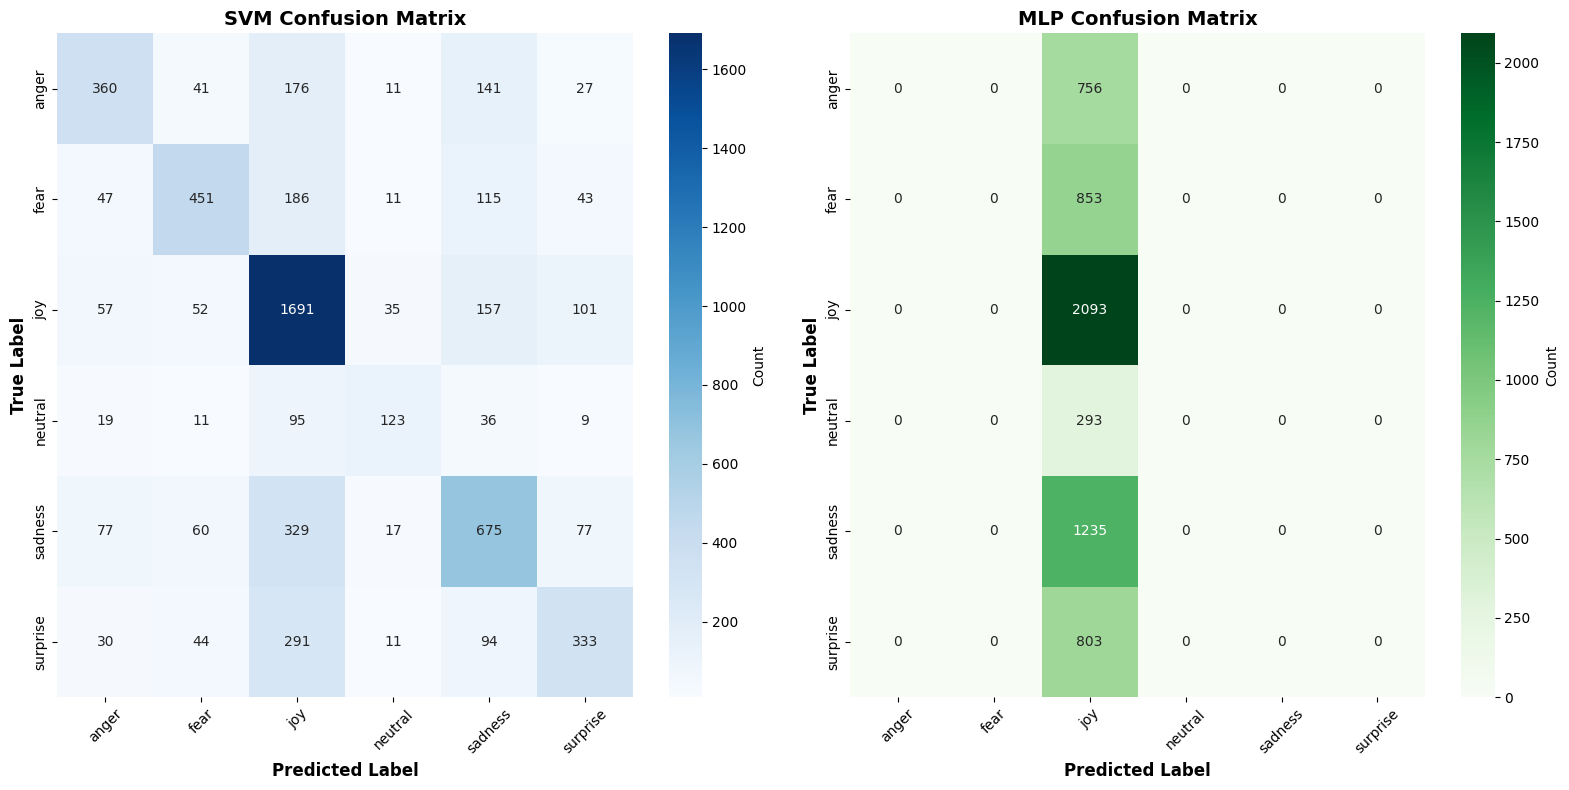

SVM CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.61      0.48      0.53       756
           1       0.68      0.53      0.60       853
           2       0.61      0.81      0.70      2093
           3       0.59      0.42      0.49       293
           4       0.55      0.55      0.55      1235
           5       0.56      0.41      0.48       803

    accuracy                           0.60      6033
   macro avg       0.60      0.53      0.56      6033
weighted avg       0.60      0.60      0.59      6033

MLP CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       756
           1       0.00      0.00      0.00       853
           2       0.35      1.00      0.52      2093
           3       0.00      0.00      0.00       293
           4       0.00      0.00      0.00      1235
           5       0.00      0.00      0.00       803

    accuracy             

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

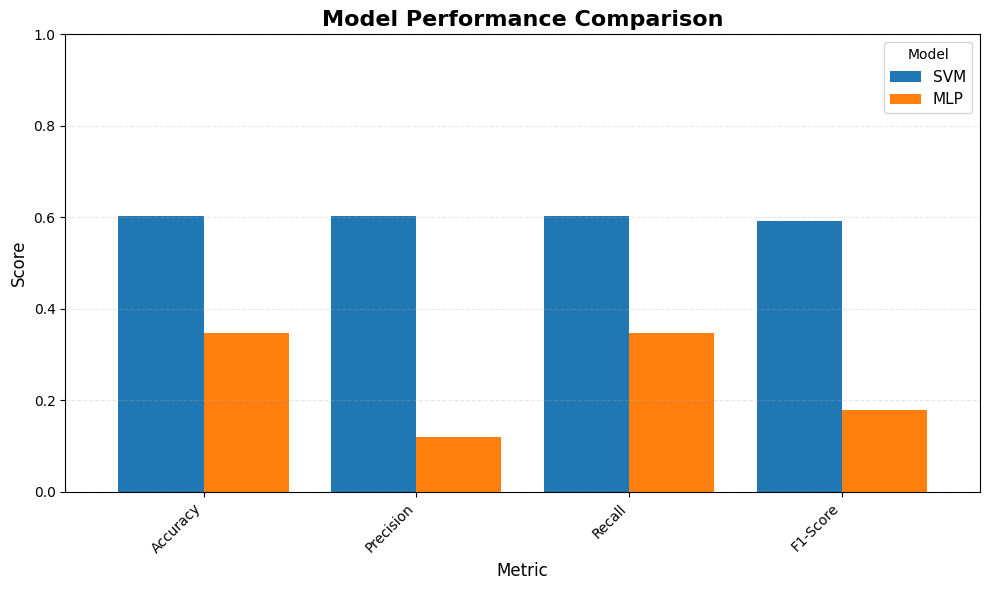

MLP TRAINING HISTORY


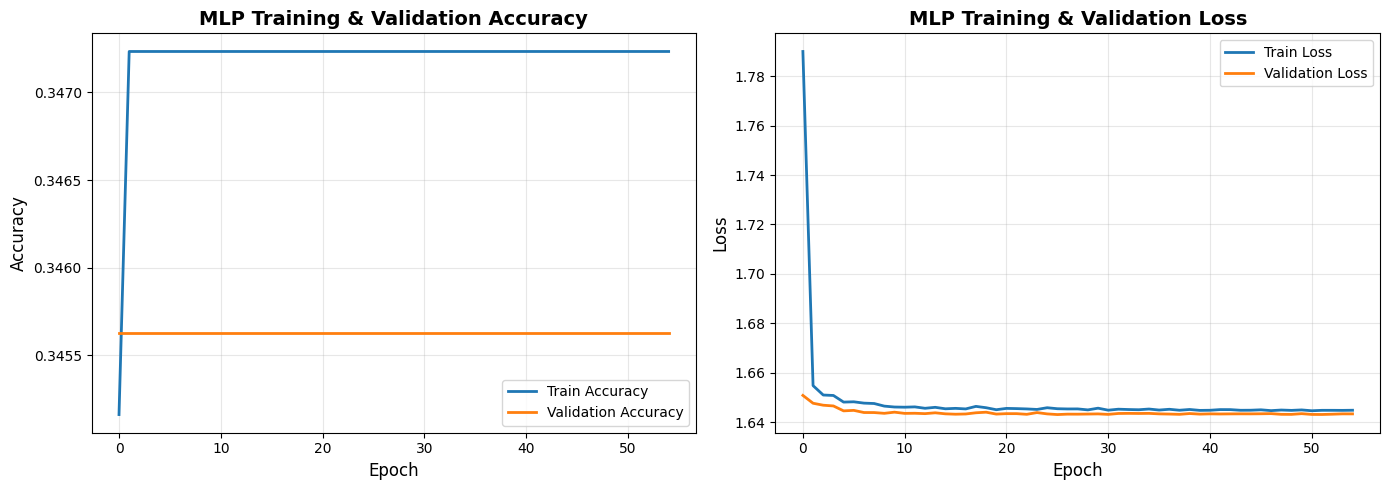

FINAL COMPARISON SUMMARY
Model Accuracy Precision Recall F1-Score
  SVM   0.6022    0.6025 0.6022   0.5929
  MLP   0.3469    0.1204 0.3469   0.1787
 Better Model: SVM
   F1-Score advantage: 41.42%


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                              accuracy_score, precision_recall_fscore_support)
import pandas as pd


print("Generating Predictions")

# SVM predictions
y_pred_svm = svm_model.predict(X_test)


# MLP predictions
y_pred_mlp_prob = model.predict(X_test)
y_pred_mlp = np.argmax(y_pred_mlp_prob, axis=1)


# Convert y_test back from categorical if needed
if len(y_test.shape) > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test



# Confuse Matrics for both SVM and MLP side by side
print("Confusion Matrics")

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test_labels, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            ax=axes[0], cbar_kws={'label': 'Count'},
            xticklabels=le.classes_,
            yticklabels=le.classes_)
axes[0].set_title('SVM Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# MLP Confusion Matrix
cm_mlp = confusion_matrix(y_test_labels, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens',
            ax=axes[1], cbar_kws={'label': 'Count'},
            xticklabels=le.classes_,
            yticklabels=le.classes_)
axes[1].set_title('MLP Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Report
print("SVM CLASSIFICATION REPORT")
print(classification_report(y_test_labels, y_pred_svm))

print("MLP CLASSIFICATION REPORT")
print(classification_report(y_test_labels, y_pred_mlp))

# Comparing performance with Bar chart
print("PERFORMANCE COMPARISON")

# Calculate metrics
svm_acc = accuracy_score(y_test_labels, y_pred_svm)
mlp_acc = accuracy_score(y_test_labels, y_pred_mlp)

svm_prec, svm_rec, svm_f1, _ = precision_recall_fscore_support(
    y_test_labels, y_pred_svm, average='weighted'
)
mlp_prec, mlp_rec, mlp_f1, _ = precision_recall_fscore_support(
    y_test_labels, y_pred_mlp, average='weighted'
)

# Create comparison dataframe
metrics_comparison = pd.DataFrame({
    'SVM': [svm_acc, svm_prec, svm_rec, svm_f1],
    'MLP': [mlp_acc, mlp_prec, mlp_rec, mlp_f1]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print(metrics_comparison)

# Visualize comparison
ax = metrics_comparison.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', fontsize=11)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


print("MLP TRAINING HISTORY")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('MLP Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('MLP Training & Validation Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary Table
print("FINAL COMPARISON SUMMARY")

summary = pd.DataFrame({
    'Model': ['SVM', 'MLP'],
    'Accuracy': [f'{svm_acc:.4f}', f'{mlp_acc:.4f}'],
    'Precision': [f'{svm_prec:.4f}', f'{mlp_prec:.4f}'],
    'Recall': [f'{svm_rec:.4f}', f'{mlp_rec:.4f}'],
    'F1-Score': [f'{svm_f1:.4f}', f'{mlp_f1:.4f}']
})

print(summary.to_string(index=False))

# Determine winner
if mlp_f1 > svm_f1:
    winner = "MLP"
    difference = (mlp_f1 - svm_f1) * 100
else:
    winner = "SVM"
    difference = (svm_f1 - mlp_f1) * 100

print(f" Better Model: {winner}")
print(f"   F1-Score advantage: {difference:.2f}%")

I have tested the models using an 80/20 train-test split with 20% validation data for MLP monitoring. Metrics include accuracy, precision, recall, and F1-score with weighted averaging for class imbalance. Confusion matrices visualize classification patterns, while MLP training curves assess learning behavior. LinearSVM has performed better with 60.22% accuracy and 0.5929 F1-score where MLP has 34.69% accuracy and 0.1787 F1-score.

The confusion matrices reveal MLP mostly predicted only "joy" for all 6,033 test samples, achieving 100% recall for joy but zero predictions for anger, fear, neutral, sadness, and surprise. SVM demonstrates balanced emotion recognition across all categories with strongest performance on joy.

MLP's training curves show rapid convergence within five epochs, stayed at poor performance, indicating fundamental learning failure rather than overfitting. This stems from sparse TF-IDF features which neural networks process ineffectively. Joy being the largest class (2,093 samples), so MLP learned to just guess Joy every time because it minimized errors. This strategy gives 35% accuracy but fails completely for other classes.
On the other hand, SVM works better with TF-IDF features, trains faster, and makes good predictions for all classes.